In [2]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import pandas as pd
import datetime

driver=webdriver.Chrome("C:/Users/pc/Main/Data_Analysis/chromedriver_win32/chromedriver.exe")
url="https://www.naver.com/"
driver.get(url)
time.sleep(3)

def naver_searching(word):
    url="https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query="+word
    return url

word="코로나현황"
url=naver_searching(word)
driver.get(url)
time.sleep(3)

def get_current_week_content(driver): #국내유입, 해외유입
    week_data_result = []
    year = str(datetime.datetime.now().year)
    for i in range(1,8):
        driver.find_element_by_css_selector("#target2 > dl > div:nth-child({})".format(i)).click()
        #time.sleep(1)
        date = driver.find_element_by_css_selector("div:nth-child(1) > dd.date._x_value").text # 날짜
        if int(date[0]) < 10:
            date = year + "0" + date.replace(".","")
        domestic = driver.find_element_by_css_selector("div:nth-child(2) > dd.desc._y_first_value").text # 국내 발생
        if "," in domestic:
            domestic = domestic.replace(",","")
        abroad = driver.find_element_by_css_selector("div:nth-child(2) > dd.desc._y_second_value").text # 해외 유입
        if "," in abroad:
            abroad = abroad.replace(",","")
        data = [int(date), int(domestic), int(abroad)]
        week_data_result.append(data)
    return week_data_result

week_data_result=get_current_week_content(driver)

time.sleep(3)

def select_map(driver): #지도 맵 선택
    result_map=driver.find_element_by_css_selector("#_cs_production_type > div > div:nth-child(4) > div > div.info_top > div > div > div > ul > li:nth-child(1) > a")
    result_map.click()
    time.sleep(3)
    
select_map(driver)
time.sleep(3)

def get_content(driver): #내용 웹크롤링
    html=driver.page_source
    soup=BeautifulSoup(html, "html.parser")
    areas=soup.select("div.local_info.type_increase")
    
    area_infomation_result=[]
    for i in range(len(areas)):
        if i not in (3, 12):
            area=areas[i]
            area_name=area.select("strong")[0].text #지역
            number=area.select("p")[0].text #확진자 수
            area_number = int(number.replace(",","")) #확진자 수 형변환
            area_infomation_result.append([area_name, area_number])
    
    return area_infomation_result
        
area_result=get_content(driver)
time.sleep(3)

def select_stage(driver): #거리두기 단계 클릭
    result_map=driver.find_element_by_css_selector("#_cs_production_type > div > div.csp_tab_area._tab_root > div > div > ul > li.tab._tab > a")
    result_map.click()
    time.sleep(3)
    
select_stage(driver)
time.sleep(3)
    
def get_stage(driver): #데이터 추출
    stage_result=[]
    for i in range(2,21):
        if i not in (5,15):
            html=driver.page_source
            soup=BeautifulSoup(html, "html.parser")
            stage=soup.select("#_cs_production_type > div > div:nth-child(6) > div > div > div > div._normality > div.patients_map > div > div:nth-child({})".format(i))
            stage_area=stage[0].select("strong")[0].text
            stage_num = int(stage[0].select("p")[0].text)
            stage_result.append([stage_area, stage_num])

    return stage_result

stage_result=get_stage(driver)

def merge_result(area_result,stage_result): #2개 데이터 합치기
    for i in range(len(stage_result)):
        area_result[i].append(stage_result[i][1])
    return area_result

area_result=merge_result(area_result,stage_result)
print("웹크롤링 완료")

웹크롤링 완료


In [3]:
#데이터프레임 변형 및 엑셀파일 생성
columns = ['날짜', '국내발생', '해외유입']
df_week_data = pd.DataFrame(week_data_result, columns = columns)
df_week_data.to_excel('C:/Users/pc/Main/Mini_project/week_Data.xlsx', index=False)
df_week_data.head(5)

,날짜,국내발생,해외유입
0,20210820,1811,66
1,20210821,1588,38
2,20210822,1369,48
3,20210823,1468,39
4,20210824,2113,41


In [4]:
#데이터프레임 변형 및 엑셀파일 생성
import pandas as pd
area_result_df=pd.DataFrame(area_result)
area_result_df.columns=["지역","확진자 수", "거리두기 단계"]
area_result_df.to_excel("C:/Users/pc/Main/Mini_project/area_info.xlsx", index=False)
area_result_df.head(5)

,지역,확진자 수,거리두기 단계
0,제주,2547,4
1,서울,77371,4
2,인천,11503,4
3,광주,3962,3
4,경북,6933,3


In [6]:
##sql에 저장하기
import pymysql

conn=pymysql.connect(host="127.0.0.1", user="root",password="hp_8_8", db="choronadb", charset="utf8") #db변경필요
cur=conn.cursor()

create_table="CREATE TABLE IF NOT EXISTS areaTable (area_name char(3), area_number int, area_stage int)" #테이블 생성
cur.execute("CREATE TABLE IF NOT EXISTS weekTable (date int, domestic int, abroad int)")
cur.execute(create_table)

for day_data in week_data_result:
    date=day_data[0]
    kg_chorona=day_data[1]
    extra_chorona=day_data[2]
    sql_1="INSERT INTO weekTable VALUES({},{},{})".format(date, kg_chorona,extra_chorona)
    cur.execute(sql_1)

for info in area_result:
    area_name=info[0]
    area_num = info[1]
    area_stage = info[2]
    sql="INSERT INTO areaTable VALUES ('{}', {},{})".format(area_name, area_num, area_stage)
    cur.execute(sql)
    
conn.commit()
conn.close()
print("sql 저장 완료")

sql 저장 완료


## SQL에 넣은 값을 가져오기

In [7]:
#sql에서 다시 연결시켜서...가져오기
import pymysql

conn=pymysql.connect(host="127.0.0.1", user="root",password="hp_8_8", db="choronadb", charset="utf8") #db변경필요
cur=conn.cursor()

sql="SELECT * FROM areaTable"
cur.execute(sql)

area_data=[]
while True:
    row=cur.fetchone()
    if row==None:
        break
    area_name=row[0]
    area_num=row[1]
    area_stage=row[2]
    data=[area_name, area_num, area_stage]
    area_data.append(data)

cur.execute("SELECT * FROM weekTable")
week_data = []
while(True):
    row = cur.fetchone()
    if row == None:
        break;
    date = row[0]
    kg_chorona = row[1]
    extra_chorona = row[2]
    week_data.append([date,kg_chorona,extra_chorona])

conn.close()
print("데이터 추출완료")

데이터 추출완료


In [8]:
columns = ['date','kg_chorona','extra_chorona']
df_week_data = pd.DataFrame(week_data, columns = columns)
df_week_data.head(5)

,date,kg_chorona,extra_chorona
0,20210820,1811,66
1,20210821,1588,38
2,20210822,1369,48
3,20210823,1468,39
4,20210824,2113,41


In [9]:
columns = ['area_name', 'area_number', 'rate']
chorona_kr = pd.DataFrame(area_data, columns = columns).sort_values(by='area_number', ascending=False)
chorona_kr.head(5)

,area_name,area_number,rate
1,서울,77371,4
8,경기,69220,4
6,대구,13377,3
2,인천,11503,4
5,부산,11145,4


In [10]:
#그래프를 위한 한글
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font',family=font_name)

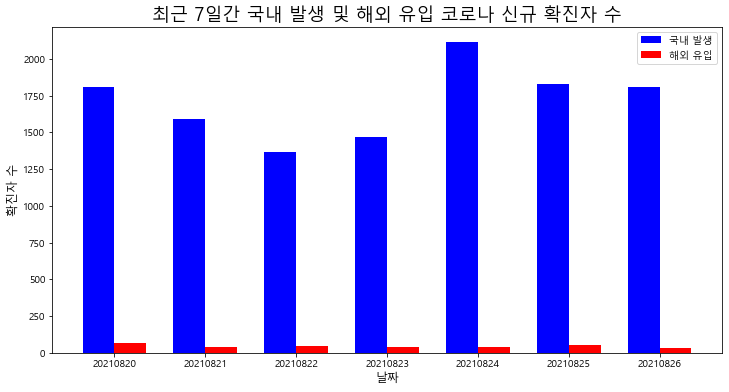

In [11]:
# 그래프 생성
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.35 # 막대 그래프 너비값
index = np.arange(len(df_week_data['date'])) # x축 데이터 - 날짜
plt.figure(figsize=(12,6))
plt.bar(index, df_week_data['kg_chorona'], bar_width, color='b', align='edge',label='국내 발생')
plt.bar(index + bar_width, df_week_data['extra_chorona'], bar_width, color='r',align='edge',label='해외 유입')
plt.title('최근 7일간 국내 발생 및 해외 유입 코로나 신규 확진자 수', fontsize=18)
plt.ylabel('확진자 수', fontsize=12)
plt.xlabel('날짜', fontsize=12)
plt.xticks(index + bar_width,df_week_data['date'])#, fontsize=15
plt.legend()# (p1[0], p2[0]), ('국내', '해외'), fontsize=15
plt.show()

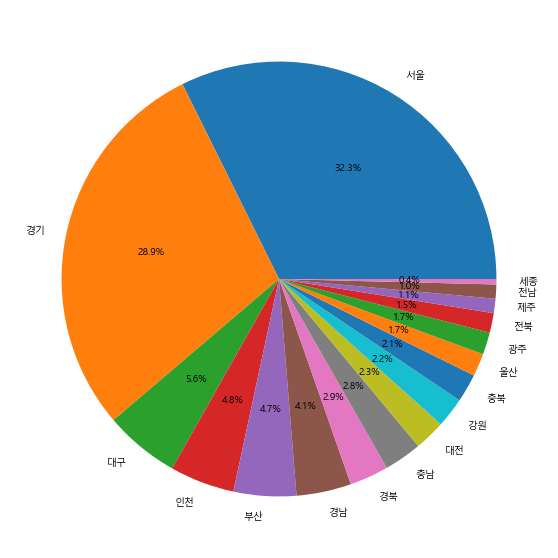

In [12]:
import matplotlib.pyplot as plt ## 국내 발생 비율 - pie
def kr_graph():
    cur.execute("SELECT * FROM chorona_kr")
    chorona_kr = []
    while(True):
        row = cur.fetchone()
        if row == None:
            break;
        area_name = row[0]
        area_number = row[1]
        chorona_kr.append([area_name, area_number])
    conn.close()
    columns = ['area_name', 'area_number', 'rate']
    chorona_kr = pd.DataFrame(area_result, columns = columns)
    #chorona_kr = chorona_kr.sort_values(by=chorona_kr['area_number'], ascending=False)
plt.figure(figsize = (30, 10))
plt.pie(chorona_kr['area_number'], labels=chorona_kr['area_name'], autopct='%1.1f%%')
plt.show()

In [13]:
#API를 사용하여 각 지역의 위도와 경도를 추출
import requests

def find_places(searching):

    url="https://dapi.kakao.com//v2/local/search/keyword.json?query={}".format(searching)

    headers={
        "Authorization":"KakaoAK 2e4f069c2431636091e30289f9dbc8c4"
    }
    places = requests.get(url, headers=headers).json()["documents"]
    place=places[0]
    x=place["x"]
    y=place["y"]
    data = [x,y]
    
    return data

place_result=[]
for area in area_data: #지역 이름만 추출
    find_place=find_places(area[0])
    place_result.append(find_place)

for i in range(len(area_data)):
    long=place_result[i][0]
    lat=place_result[i][1]
    area_data[i].append(long) #위도 넣기
    area_data[i].append(lat) #경도 넣기
    
area_result=pd.DataFrame(area_data)
area_result.columns=["지역","확진자 수","거리두기 단계","위도","경도"]
area_result

,지역,확진자 수,거리두기 단계,위도,경도
0,제주,2547,4,126.51530966206293,33.23738579332568
1,서울,77371,4,126.93626843562683,37.62612118319853
2,인천,11503,4,126.76017260475932,37.457761295660084
3,광주,3962,3,126.89424238616951,35.22431406471364
4,경북,6933,3,129.282030311373,35.8367452157966
5,부산,11145,4,129.159854668484,35.1585232170784
6,대구,13377,3,128.56658131032162,35.85322716591636
7,강원,5325,3,128.910210247605,37.8034055083125
8,경기,69220,4,126.9950525295552,37.685112988816826
9,전남,2503,3,127.74547599836,34.778856828051


In [14]:
#지도 만들기
import folium

sejong=[36.48, 127.29]
map_korea = folium.Map(location=sejong, zoom_start=7)

for i in range(len(area_result)):
    area_name=area_result["지역"][i]
    area_num=area_result["확진자 수"][i]
    long=float(area_result["위도"][i])
    lat=float(area_result["경도"][i])
    size=int(area_num)/1000
    folium.CircleMarker((lat, long), radius=size, color="red", popup=area_name).add_to(map_korea)

map_korea